In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [20]:
df_train = pd.read_csv('../../data_new/train_pre.csv').drop_duplicates()
df_test = pd.read_csv('../../data_new/test_pre.csv').drop_duplicates()

In [21]:
def pooled_var(stds):
    n = 3 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

In [38]:
def plot_cv_results(gs_model, gs_params):
    df = pd.DataFrame(gs_model.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']


    fig, axes = plt.subplots(1, len(gs_params), 
                            figsize = (5*len(gs_params), 7),
                            sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)
    lw = 2

    for idx, (param_name, param_range) in enumerate(gs_params.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        # axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
        #                 grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
        #                 color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        # axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
        #                 grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
        #                 color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [23]:
def get_score(pred, actual):
    if np.argmin(pred) == np.argmin(actual):
        return 1
    return 0

In [24]:
def get_metrics(model, x, y):
    precision = 0
    accuracy = 0
    recall = 0
    f1 = 0
    score = 0
    for i in x['raceId'].unique():
        X_test = x[x['raceId'] == i]
        Y_test = y[x[x['raceId'] == i].index]

        predicted_scores = model.predict(X_test.drop(columns = ['results_positionOrder']))
        predicted_podium = np.argsort(predicted_scores)[::-1]
        # print(self.position[x[x['raceId'] == i].index])
        actual_podium = X_test['results_positionOrder'].to_numpy()
        actual_podium = np.argsort(actual_podium)
        # print(predicted_scores)

        predictions = np.zeros(len(Y_test))
        # predictions[predicted_podium] = 1
        actual = np.zeros(len(Y_test))
        # actual[actual_podium] = 1

        for i in range(1):
            predictions[predicted_podium[i]] = 1
            # print(actual_podium)
            actual[actual_podium[i]] = 1

        precision += precision_score(actual, predictions)
        accuracy += accuracy_score(actual, predictions)
        recall += recall_score(actual, predictions)
        f1 += f1_score(actual, predictions) 
        score += get_score(predicted_podium, actual_podium)
    return precision/len(x['raceId'].unique()), accuracy/len(x['raceId'].unique()), recall/len(x['raceId'].unique()), f1/len(x['raceId'].unique()), score/len(x['raceId'].unique())
        

In [25]:
class customCrossValidation():

    def split(self, x):
        indices = []
        for i in range(3):
            years = x['year'].unique()
            np.random.shuffle(years)
            val_years = years[:6]
            train_years = years[6:]

            indices.append((x[x['year'].isin(train_years)].index, x[x['year'].isin(val_years)].index))
        return indices

In [26]:
class mlpRegressor() :

    def scoring(self, model, x, y):

        precision = 0
        accuracy = 0
        recall = 0
        f1 = 0
        score = 0
        for i in x['raceId'].unique():
            X_test = x[x['raceId'] == i]
            Y_test = y[x[x['raceId'] == i].index]

            predicted_scores = model.predict(X_test)
            predicted_podium = np.argsort(predicted_scores)[::-1]
            # print(self.position[x[x['raceId'] == i].index])
            actual_podium = self.position[x[x['raceId'] == i].index].to_numpy()
            actual_podium = np.argsort(actual_podium)
            # print(predicted_scores)

            predictions = np.zeros(len(Y_test))
            # predictions[predicted_podium] = 1
            actual = np.zeros(len(Y_test))
            # actual[actual_podium] = 1

            for i in range(1):
                predictions[predicted_podium[i]] = 1
                # print(actual_podium)
                actual[actual_podium[i]] = 1

            precision += precision_score(actual, predictions)
            accuracy += accuracy_score(actual, predictions)
            recall += recall_score(actual, predictions)
            f1 += f1_score(actual, predictions) 
            score += get_score(predicted_podium, actual_podium)
        
        # self.ridge_metrics = {'precision': precision/len(x['raceId'].unique()), 'accuracy': accuracy/len(x['raceId'].unique()), 'recall': recall/len(x['raceId'].unique()), 'f1': f1/len(x['raceId'].unique())}
        return precision/len(x['raceId'].unique())

    def find_best_param_mlpr(self, x, y):

        self.x = x
        self.y = y
        self.position = x['results_positionOrder']

        splitter = customCrossValidation().split(x)
        self.hyper_params = [{'activation': ['identity', 'logistic', 'tanh', 'relu'], 'learning_rate_init': [1, 0.1, 0.01, 0.001], 'hidden_layer_sizes': [(256,32), (128,16),(64,8)], 'batch_size': [64,128,256]}]

        model_mlpr = MLPRegressor()
        self.model_cv = GridSearchCV(estimator=model_mlpr, param_grid=self.hyper_params, scoring=self.scoring, cv = splitter, return_train_score=True, verbose = 3)
        self.model_cv.fit(x.drop(columns = ['results_positionOrder']), y)
        self.mlpr_params = self.model_cv.best_params_

    def fit_mlpr(self, x, y):
        model = MLPRegressor(**self.mlpr_params)
        model.fit(x.drop(columns = ['results_positionOrder']), y)
        self.model = model
        return
        


In [27]:
mlpr = mlpRegressor()

In [28]:
mlpr.find_best_param_mlpr(df_train.drop(columns = ['results_points']), df_train['results_points'])

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END activation=identity, batch_size=64, hidden_layer_sizes=(256, 32), learning_rate_init=1;, score=(train=0.374, test=0.379) total time=   8.0s
[CV 2/3] END activation=identity, batch_size=64, hidden_layer_sizes=(256, 32), learning_rate_init=1;, score=(train=0.505, test=0.394) total time=  14.8s
[CV 3/3] END activation=identity, batch_size=64, hidden_layer_sizes=(256, 32), learning_rate_init=1;, score=(train=0.512, test=0.528) total time=  10.3s
[CV 1/3] END activation=identity, batch_size=64, hidden_layer_sizes=(256, 32), learning_rate_init=0.1;, score=(train=0.495, test=0.448) total time=   3.9s
[CV 2/3] END activation=identity, batch_size=64, hidden_layer_sizes=(256, 32), learning_rate_init=0.1;, score=(train=0.467, test=0.413) total time=   2.8s
[CV 3/3] END activation=identity, batch_size=64, hidden_layer_sizes=(256, 32), learning_rate_init=0.1;, score=(train=0.488, test=0.500) total time=   2.7s
[CV 1/3] END 

In [29]:
mlpr.mlpr_params

{'activation': 'logistic',
 'batch_size': 64,
 'hidden_layer_sizes': (256, 32),
 'learning_rate_init': 0.001}

In [30]:
mlpr.fit_mlpr(df_train.drop(columns = ['results_points']), df_train['results_points'])

In [31]:
get_metrics(mlpr.model, df_test.drop(columns = ['results_points']), df_test['results_points'])

(0.51, 0.9571134937318666, 0.51, 0.51, 0.24)

In [37]:
mlpr.model_cv
mlpr.hyper_params[0]

{'activation': ['identity', 'logistic', 'tanh', 'relu'],
 'learning_rate_init': [1, 0.1, 0.01, 0.001],
 'hidden_layer_sizes': [(256, 32), (128, 16), (64, 8)],
 'batch_size': [64, 128, 256]}

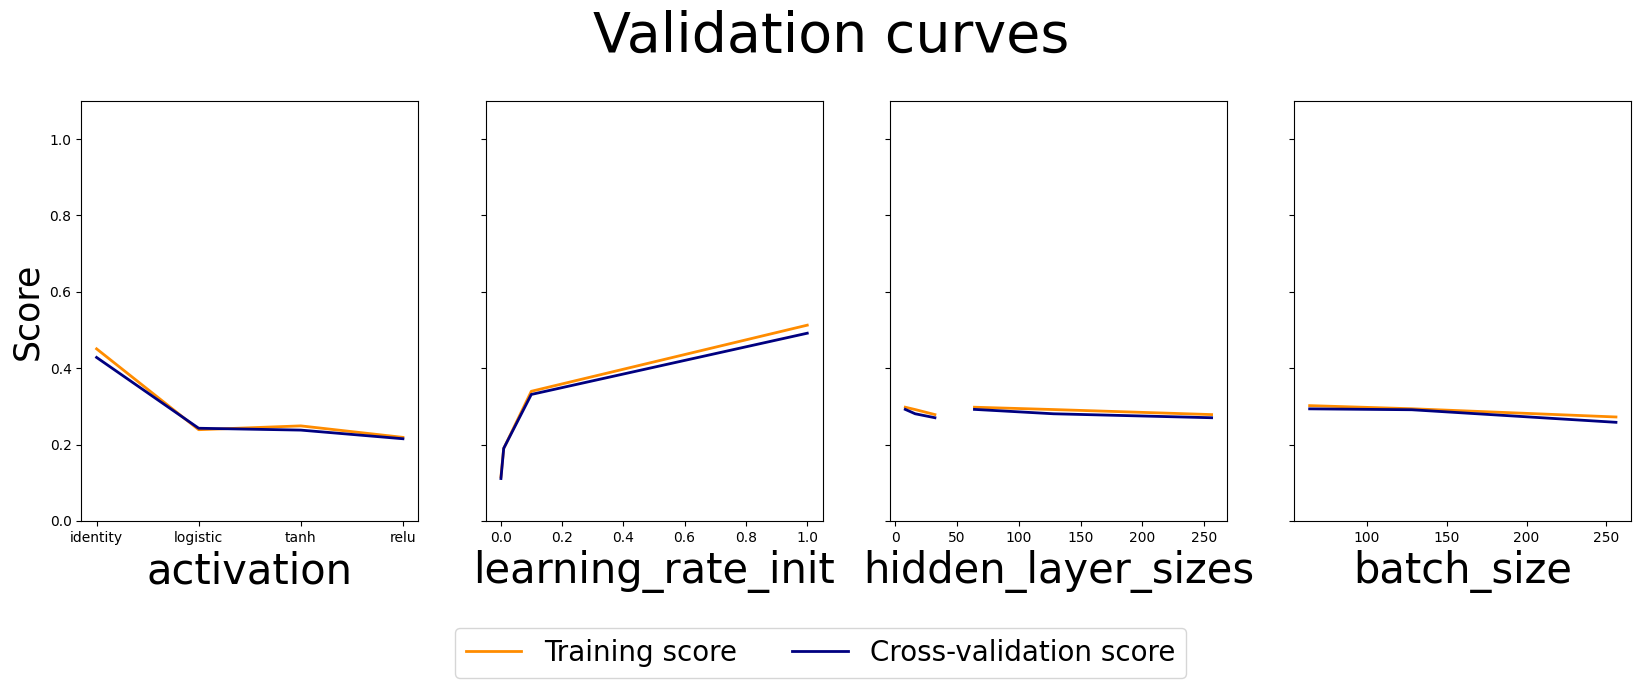

In [39]:
plot_cv_results(mlpr.model_cv, mlpr.hyper_params[0])